<a href="https://colab.research.google.com/github/ds4geo/ds4geo/blob/master/DS4GEO_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Topics:
1. Indexing lists
2. Dicts and indexing dicts
3. (Functions, methods, attributes)

With Spannagel example:
5. array operations - Spannagel
6. aggregations - Spannagel
4. np indexing: argmax vs boolean array indexing examples

LA-ICPMS excercise is stringing it all together

In [2]:
file_name_list = ["STD-1.csv","Sample-1.csv"]
data_list = []
for fn in file_name_list:
  data_list.append(pd.read_csv(r"https://raw.githubusercontent.com/oscarbranson/latools/master/tests/test_dir/test_data/"+fn, header=3))
data_list[1]["Time [Sec]"] = data_list[1]["Time [Sec]"] + data_list[0]["Time [Sec]"].max()
data = pd.concat(data_list)

In [3]:
data

,Time [Sec],Mg24,Mg25,Al27,Ca43,Ca44,Mn55,Sr88,Ba137,Ba138
0,0.367,200.00,300.00,2200.14,366.67,17809.04,8652.16,0.00,0.0,12.5
1,0.725,466.67,200.00,2800.22,200.00,14506.00,7551.64,0.00,0.0,12.5
2,1.082,366.67,175.00,2000.11,466.67,13255.01,7151.47,100.00,25.0,0.0
3,1.439,466.67,75.00,1600.07,300.00,14405.92,8652.16,33.33,0.0,0.0
4,1.796,466.67,225.00,3000.25,200.00,14506.00,7551.64,100.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,497.717,166.67,150.00,2400.16,433.34,14105.67,6801.33,66.67,0.0,0.0
695,498.074,466.67,275.00,3200.29,300.00,14606.08,8702.18,33.33,0.0,25.0
696,498.431,200.00,350.00,3100.27,400.00,14455.96,9102.38,133.33,0.0,0.0
697,498.788,333.34,500.01,2500.18,100.00,13505.20,8452.06,33.33,50.0,25.0


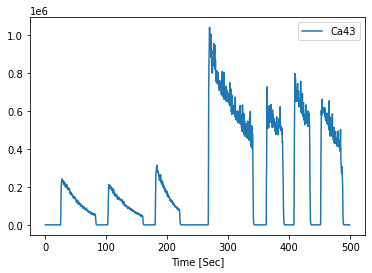

In [4]:
data.plot("Time [Sec]", "Ca43")

In [5]:
# convert to numpy and split into time and trace elment data
dat = data.to_numpy()
time = dat[:,0]
raw_te = dat[:,1:]

**1. Identify background and apply background correction**
1. Identify Signal (Sample and Standard), and Background parts of signal
Do manually - can be done with GUI or algorithms, but do it manually now to teach basics.

A) Create list of start and end values for the first and last background sections

In [6]:
%matplotlib inline


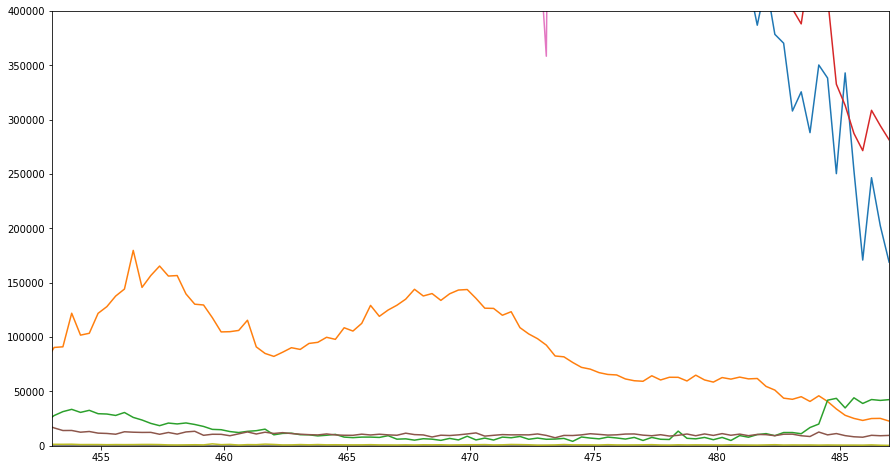

In [7]:

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time, raw_te)
plt.plot()
plt.xlim(453,487)
plt.ylim(0,0.4e6)
fig.show()

In [8]:
bg_loc = [{"start": 0, "end": 25},
          {"start": 491, "end": 498}]
stand_loc = [{"start": 27, "end": 82},
            {"start": 105, "end": 160},
            {"start": 184, "end": 220},
            ]
samp_loc = [{"start": 269, "end": 340 },
            {"start": 363, "end": 389},
            {"start": 409, "end": 433},
            {"start": 453, "end": 487}]

In [9]:
# Slice background locations
bg_te = raw_te[np.logical_or(np.logical_and(time > bg_loc[0]["start"], time < bg_loc[0]["end"]),
                     np.logical_and(time > bg_loc[1]["start"], time < bg_loc[1]["end"]) )]

In [10]:
# Calculate stats
bg_vals = np.mean(bg_te, axis=0)

In [11]:
# Apply correction (to all data)
bgcorr_te = raw_te - bg_vals

In [12]:
# Create index for sample and standard locations
samp_loc_idx = [np.logical_and(time >= j["start"], time <= j["end"]) for j in samp_loc]
samp_idx = np.any(np.vstack(samp_loc_idx), axis=0)
stand_loc_idx = [np.logical_and(time >= j["start"], time <= j["end"]) for j in stand_loc]
stand_idx = np.any(np.vstack(stand_loc_idx), axis=0)
samp_stand_idx = np.logical_or(samp_idx, stand_idx)

In [13]:
# Clear data from non-sample areas
bgcorr_te[~samp_stand_idx,:] = np.nan

**2. Standardize to Ca**

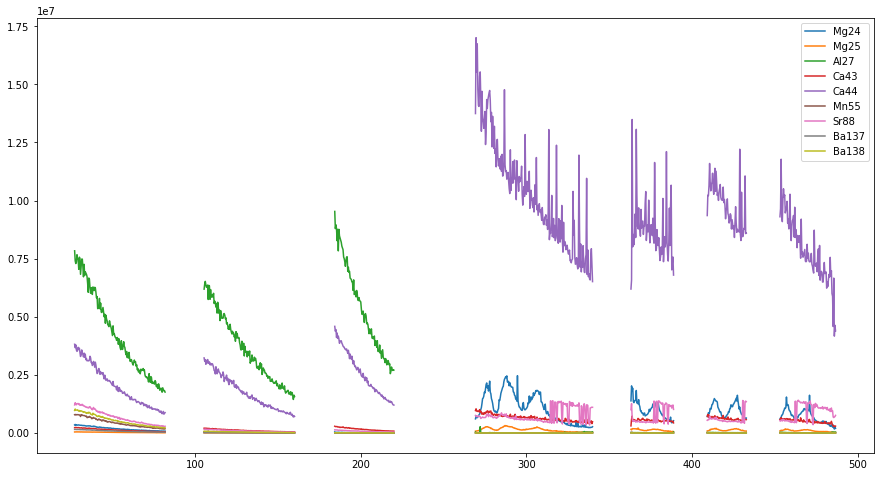

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time, bgcorr_te)
plt.plot()
ax.legend(data.columns[1:])
#plt.xlim(470,500)
#plt.ylim(0,0.3e6)

In [15]:
# Standardize to Ca44
castd_te = bgcorr_te / bgcorr_te[:,4:5]

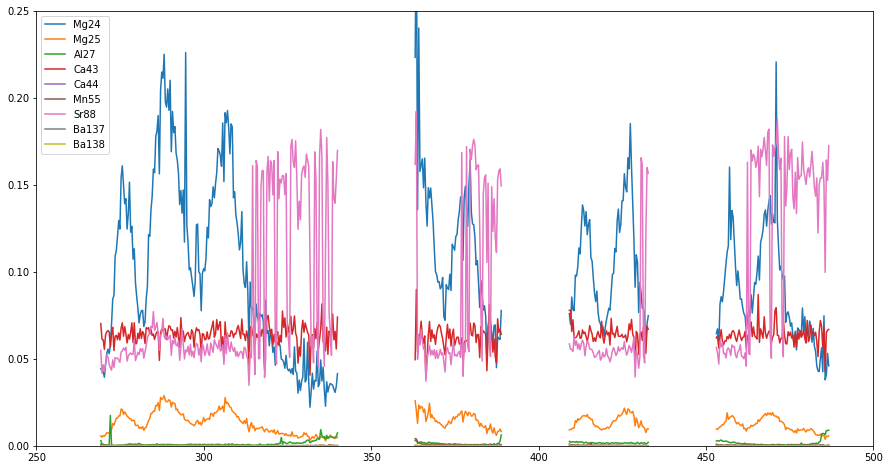

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time, castd_te)
ax.set_xlim(250,500)
ax.set_ylim(0,0.25)
ax.legend(data.columns[1:])

**3. Calibrate to standards**

In [17]:
castd_te[200:201,:]

array([[0.08861389, 0.01181638, 1.93652999, 0.06140808, 1.        ,
        0.21942866, 0.33698837, 0.0383888 , 0.25780047]])